<a href="https://colab.research.google.com/github/rlsummerschool/practical-sessions/blob/master/notebooks/bandits_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bandit Algorithms

This practical session of [RLSS 2023](https://rlsummerschool.com/) is based on the lectures on Stochastic Multi-Armed Bandits by Emilie Kaufmann ([slides](https://drive.google.com/file/d/1CXrOd8Ltc5x9QmAGmxNWaYmWgZY5V2kJ/view?usp=sharing)) and on Contextual Bandits by Claire Vernade ([slides](https://drive.google.com/file/d/11G6_mvo9DY1nQR3qsZ6X__3TpPTcBFXH/view?usp=sharing)).

It was developed by [Julia Olkhovskaya](https://sites.google.com/view/julia-olkhovskaya/home) and Matteo Papini building upon notebooks by Claire Vernade.

As a motivation for this tutorial, we consider the multiple choice testing for the webpage design problem.

Good design of a webpage is not only about the matching colours and useful
interfaces. Even if one website
design seems to be the most rational for the designer, it is usually hard to
predict which webpage design users will like the most. Therefore, the
important part of the webpage design is the testing on the real users.
Since displaying the webpage with bad design means the loss of the money,
we need to develop a mecanism that chooses the page design that is
the best most of time.
Your objective is to build a desision support system which chooses the website design at each time step without any prior knowledge.

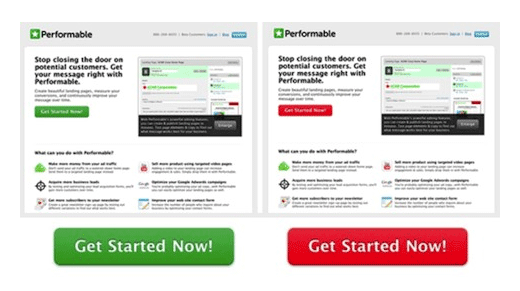

In [3]:
#Set up the environment
!pip install "git+https://github.com/rlsummerschool/practical-sessions.git" --quiet

In [4]:
#A bunch of imports
import numpy as np

from rlss_practice.model import Environment, Agent, MAB_env
from rlss_practice.display import plot_result


from scipy.stats import bernoulli
from math import log
import random

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('seaborn-v0_8')

# Multi-Armed Bandits

We formulate the choice design of a webpage design as a multi-armed bandit problem.  We
will use the synthetically generated “visits” of users, for each user the system will recommend the version of the website, so each version of the website is an arm. We model the engagement score (~#clicks) corresponding to the of version of the website as a Gaussian random variable. 

## Interaction protocol
Highlight here the difference between what we can observe in practice (rewards) and what we can evaluate for scientific experiments (regrets)

In [29]:
#The function play runs one path of regret for one agent:

def play_mab(environment, agent, N, T):
    """
    Play N trajectories over a horizon T for the specified agent.
    Return the agent's name (string) and the collected data in an nd-array.
    """

    rewards = np.zeros((N, T))
    regrets = np.zeros((N, T))
    pseudo_regrets = np.zeros((N, T))
    avg_rewards = np.zeros((N, T))

    for n in range(N):
        agent.reset()
        for t in range(T):
            action = agent.get_action()
            reward = environment.get_reward(action)
            agent.receive_reward(action,reward)
            rewards[n,t] = reward
            # compute instantaneous regret
            means = environment.get_means()
            best_reward = np.max(means)
            regrets[n,t]= best_reward - reward # this can be negative due to the noise, but on average it's positive
            avg_rewards[n,t] = means[action]
            pseudo_regrets[n,t] = best_reward - means[action]

    return agent.name(), rewards, regrets, avg_rewards, pseudo_regrets


def experiment_mab(environment, agents, N, T, mode="regret"):
    """
    Play N trajectories for all agents over a horizon T. Store all the data in a dictionary.
    """

    all_data = {}

    for agent in agents:
        agent_id, rewards, regrets, avg_rewards, pseudo_regrets = play_mab(environment, agent, N, T)

        if mode == "regret":
            all_data[agent_id] = regrets
        elif mode == "pseudo regret":
            all_data[agent_id] = pseudo_regrets
        elif mode == "reward":
            all_data[agent_id] = rewards
        elif mode == "average reward":
            all_data[agent_id] = avg_rewards
        else:
            raise ValueError

    return all_data

## Multi-Armed Bandit

In [30]:
K = 3  # number of arms

means = np.array([0.1, 0.5, 0.9])

T = 1000  # Horizon
N = 50  # Monte Carlo simulations

delta = 0.05 # could be set directly in the algorithms

# save subsampled points for Figures
Nsub = 100
tsav = range(2, T, Nsub)

#choice of percentile display
q = 10

### (Epsilon) Greedy

The idea is to give them a 3-arms bandit with Gaussian rewards and an incomplete implementation of epsilon-greedy that is just greedy/FTL. The exercise is to see the failure of FTL, complete the implementation of epsilon-greedy and try to tune the epsilon. Also visualize both reward and regret plots and learn to interpret them

In [31]:
class EpsilonGreedy(Agent):
  def __init__(self, K, eps=0.1):
    self.eps = eps # exploration probability
    self.K = K
    self.reset()

    self.cumulative_reward = np.zeros(self.K)
    self.num_played = np.zeros(self.K)
    self.avg_rewards = np.zeros(self.K)


  def reset(self):
    self.t = 0
    self.avg_rewards = np.zeros(self.K)
    self.cumulative_reward = np.zeros(self.K)
    self.num_played = np.zeros(self.K)

  def get_action(self):
    #TO FILL:
    u = np.random.random()
    if u<self.eps:
        return np.random.choice(self.K)
    else:
    #END
    #only this part is given (greedy):
        chosen_arm_index = np.argmax(self.avg_rewards)
        return chosen_arm_index

  def receive_reward(self, chosen_arm, reward):
    self.cumulative_reward[chosen_arm] += reward
    self.num_played[chosen_arm] += 1
    self.avg_rewards[chosen_arm] = self.cumulative_reward[chosen_arm]/self.num_played[chosen_arm] # update

    self.t += 1

  def name(self):
    return 'EGreedy('+str(self.eps)+')'

In [32]:
env = MAB_env(means)
greedy = EpsilonGreedy(K,  eps=0.)
epsilon_greedy = EpsilonGreedy(K,  eps=0.1)


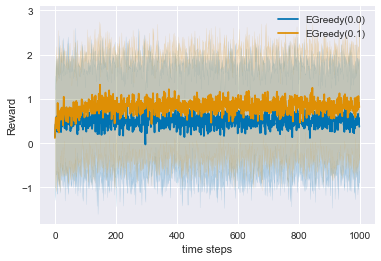

In [33]:
greedy_experiment = experiment_mab(env, [greedy, epsilon_greedy], N=N, T=T, mode="reward")
plot_result(greedy_experiment, q=10, mode="reward", cumulative=False);

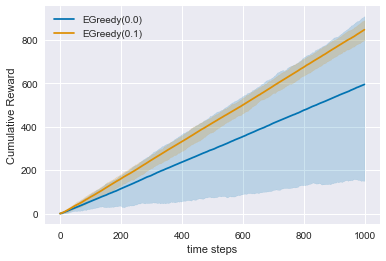

In [34]:
greedy_experiment = experiment_mab(env, [greedy, epsilon_greedy], N=N, T=T, mode="reward")
plot_result(greedy_experiment, q=10, mode="reward", cumulative=True);

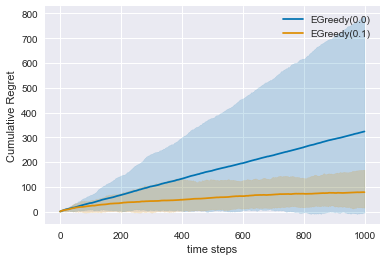

In [35]:
greedy_experiment = experiment_mab(env, [greedy, epsilon_greedy], N=N, T=T, mode="regret")
plot_result(greedy_experiment, q=10, mode="regret");

### UCB

Idea: just implement the UCB score and compare with epsilon-greedy

In [36]:
class UCB(Agent):
  def __init__(self, K, alpha=2.):
    self.alpha = alpha
    self.K = K
    self.reset()

    self.cumulative_reward = np.zeros(self.K)
    self.num_played = np.zeros(self.K)
    self.avg_rewards = np.zeros(self.K)


  def reset(self):
    self.t = 0
    self.avg_rewards = np.zeros(self.K)
    self.num_played = np.zeros(self.K)
    self.cumulative_reward = np.zeros(self.K)


  def get_action(self):
    #TO FILL:
    with np.errstate(divide='ignore'):
        bonuses = np.sqrt(self.alpha * np.log((self.t + 1)) / self.num_played)
    scores = self.avg_rewards + bonuses
    ##END

    chosen_arm_index = np.argmax(scores)
    return chosen_arm_index

  def receive_reward(self, chosen_arm, reward):
    self.cumulative_reward[chosen_arm] += reward
    self.num_played[chosen_arm] += 1
    self.avg_rewards[chosen_arm] = self.cumulative_reward[chosen_arm]/self.num_played[chosen_arm]

    self.t += 1

  def name(self):
    return 'UCB('+str(self.alpha)+')'

/var/folders/xf/z7gtg8ps07x3npl9hqks2f5c0000gn/T/ipykernel_23325/2834098210.py:22: RuntimeWarning: invalid value encountered in divide
  bonuses = np.sqrt(self.alpha * np.log((self.t + 1)) / self.num_played)


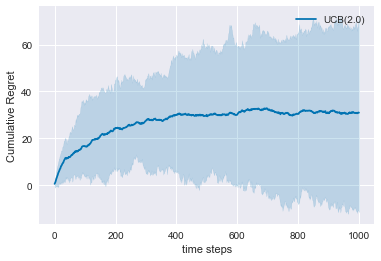

In [37]:
env = MAB_env(means)
epsilon_greedy = EpsilonGreedy(K,  eps=0.1)
ucb = UCB(K,  alpha=2.)
ucb_experiment = experiment_mab(env, [ucb], N=N, T=T, mode="regret")
plot_result(ucb_experiment, q=10);

/var/folders/xf/z7gtg8ps07x3npl9hqks2f5c0000gn/T/ipykernel_23325/2834098210.py:22: RuntimeWarning: invalid value encountered in divide
  bonuses = np.sqrt(self.alpha * np.log((self.t + 1)) / self.num_played)


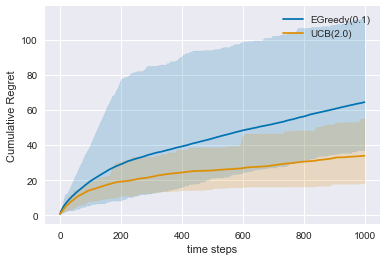

In [14]:
env = MAB_env(means)
epsilon_greedy = EpsilonGreedy(K,  eps=0.1)
ucb = UCB(K,  alpha=2.)
ucb_experiment = experiment_mab(env, [epsilon_greedy, ucb], N=N, T=T, mode="pseudo regret")
plot_result(ucb_experiment, q=10);

## Thompson Sampling

Idea: briefly show how TS with Gaussian prior and likelihood is equivalent to adding Gaussian noise to avg rewards; implement the TS "scores" and compare with epsilon-greedy

In [15]:
class ThompsonSampling(Agent):
  def __init__(self, K, sigma=1.):
    self.sigma = sigma #prior std
    self.K = K
    self.reset()

    self.cumulative_reward = np.zeros(self.K)
    self.num_played = np.zeros(self.K)
    self.avg_rewards = np.zeros(self.K)
    self.stds = self.sigma * np.ones(self.K) #TO FILL


  def reset(self):
    self.t = 0
    self.avg_rewards = np.zeros(self.K)
    self.cumulative_reward = np.zeros(self.K)
    self.num_played = np.zeros(self.K)
    self.stds = self.sigma * np.ones(self.K) #TO FILL

  def get_action(self):
    #TO FILL:
    scores = np.random.normal(self.avg_rewards, self.stds)
    ##END
    chosen_arm_index = np.argmax(scores)
    return chosen_arm_index

  def receive_reward(self, chosen_arm, reward):
    self.cumulative_reward[chosen_arm] += reward
    self.num_played[chosen_arm] += 1
    self.avg_rewards[chosen_arm] = self.cumulative_reward[chosen_arm]/self.num_played[chosen_arm]

    self.stds[chosen_arm] = self.sigma / np.sqrt(self.num_played[chosen_arm]) #TO FILL
    #self.stds[chosen_arm] = self.sigma / self.num_played[chosen_arm]

    self.t += 1

  def name(self):
    return 'TS('+str(self.sigma)+')'

/var/folders/xf/z7gtg8ps07x3npl9hqks2f5c0000gn/T/ipykernel_23325/2834098210.py:22: RuntimeWarning: invalid value encountered in divide
  bonuses = np.sqrt(self.alpha * np.log((self.t + 1)) / self.num_played)


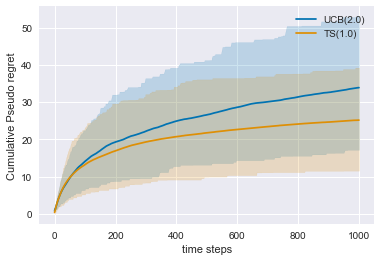

In [16]:
env = MAB_env(means)
ucb = UCB(K,  alpha=2.)
ts = ThompsonSampling(K, sigma=1.)
ts_experiment = experiment_mab(env, [ucb, ts], N=200, T=1000, mode="pseudo regret")
plot_result(ts_experiment, q=10, mode="pseudo regret");

# Linear Contextual Bandits

Now, we want to develop a personalised system, taking into account that differnt users may like different versions of the website. We assume that for each pair of user features $u$ and website version $w$, there is a feature map $\phi(u,w) \in \mathcal{R}^d$, such that  $f_\theta(u,w) = \phi(u,w)^\top \theta + \epsilon_t$, where $\epsilon_t \sim  N(0, \sigma^2)$.

We reduce this problem to the linear bandit problem, introduced on the lecture. The actions are now vectors in $R^d$, representing contextual features $x_t = \phi(u_t,w)$, and the environment is assumed to generate rewards according to some hidden linear function $y_t = x_t^\top \theta + \epsilon_t$. 

In [17]:
def randomActionsGenerator(K,d, mean=None):
    """
    K: int -- number of action vectors to be generated
    d : int -- dimension of the action space
    returns : an array of K vectors uniformly sampled on the unit sphere in R^d
    """
    if mean is None:
        mean = np.zeros(d)
    vecs = np.random.multivariate_normal(mean, np.eye(d), size=K)
    norms = np.linalg.norm(vecs,axis=1)
    return vecs / norms[:,np.newaxis]

In [18]:
class LinearBandit(Environment):

    def __init__(self, theta, K, pb_type, var=1., fixed_actions=None):
        """
        theta: d-dimensional vector (bounded) representing the hidden parameter
        K: number of actions per round (random action vectors generated each time)
        """
        self.d = np.size(theta)
        self.theta = theta
        self.K = K
        self.var = var
        self.current_action_set = np.zeros(self.d)
        self.pb_type = pb_type
        if self.pb_type not in ['fixed', 'iid']:
            raise ValueError(pb_type, "this type of problem is unknown, either change it or define it :)")

        #Now, set up the game for the given type:
        if self.pb_type == 'fixed':
            if fixed_actions is not None:

                self.K, action_dim = fixed_actions.shape #safety reset of self.K in case different
                if action_dim != self.d: # safety check
                    raise ValueError(fixed_actions, "actions dimension and theta mismatch: fix your actions.")
                self.fixed_actions = fixed_actions
            else:
                #create a fixed action set:
                self.fixed_actions = randomActionsGenerator(self.K, self.d)

            self.current_action_set = self.fixed_actions

        elif self.pb_type == 'iid':
            # generate a random set
            self.current_action_set = randomActionsGenerator(self.K, self.d)


    def get_action_set(self):
        if self.pb_type == 'fixed':
            self.current_action_set = self.fixed_actions
            return self.current_action_set
        elif self.pb_type == 'iid':
            self.current_action_set = randomActionsGenerator(self.K, self.d)
            return self.current_action_set


    def get_reward(self, action):

        """ sample reward given action and the model of this bandit environment
        action: d-dimensional vector (action chosen by the learner)
        """
        mean = np.dot(action, self.theta)
        return np.random.normal(mean, scale=self.var)

    def get_means(self):
        return np.dot(self.current_action_set, self.theta)





In [19]:
def play_linb(environment, agent, Nmc, T):
    """
    Play one Nmc trajectories over a horizon T for the specified agent.
    Return the agent's name (sring) and the collected data in an nd-array.
    """

    data = np.zeros((Nmc, T))


    for n in range(Nmc):
        agent.reset()
        for t in range(T):
            action_set = environment.get_action_set()
            action = agent.get_action(action_set)
            # Note that the main difference with the previous lab is that now get_action needs to receive the action_set
            reward = environment.get_reward(action)
            agent.receive_reward(action,reward)

            # compute instant regret
            means = environment.get_means()
            best_reward = np.max(means)
            data[n,t]= best_reward - np.dot(action, environment.theta) # pseudo regret

    return agent.name(), data


def experiment_linb(environment, agents, Nmc, T):
    """
    Play Nmc trajectories for all agents over a horizon T. Store all the data in a dictionary.
    """

    all_data = {}

    for agent in agents:
        agent_id, regrets = play_linb(environment, agent,Nmc, T)

        all_data[agent_id] = regrets

    return all_data

**Implementation of LinEpsilonGreedy**

Compute the least squares estimate $\hat{\theta}_t = V_t^{-1}X_{1:t}y_{1:t}$ and play $x_t = arg max_x x^T \hat{\theta}_t $ with probability $\epsilon$ and any action uniformly at random othervise.

In [20]:
from numpy.linalg import pinv

class LinEpsilonGreedy(Agent):
  def __init__(self, d,lambda_reg, eps=0.1,):
    self.eps = eps # exploration probability
    self.d = d
    self.lambda_reg = lambda_reg
    self.reset()

  def reset(self):
    self.t = 0
    self.hat_theta = np.zeros(self.d)
    self.cov = self.lambda_reg * np.identity(self.d)
    self.invcov = np.identity(self.d)
    self.b_t = np.zeros(self.d)


  def get_action(self, arms):
    K, _ = arms.shape

    #your code:
    u = np.random.random()
    if u<self.eps:
        return arms[np.random.choice(K)]
    #end your code
    else:
        estimated_means = np.dot(arms, self.hat_theta)
        chosen_arm_index = np.argmax(estimated_means)
        return arms[chosen_arm_index,:]

  def receive_reward(self, chosen_arm, reward):
    """
    update the internal quantities required to estimate the parameter theta using least squares
    """

    #update inverse covariance matrix
    #your code:
    xxt = np.outer(chosen_arm, chosen_arm.T)
    self.cov += xxt
    self.invcov = pinv(self.cov)

    #update b_t

    self.b_t += reward * chosen_arm

    self.hat_theta = np.inner(self.invcov, self.b_t) # update the least square estimate

    #end your code
    self.t += 1

  def name(self):
    return 'LinEGreedy('+str(self.eps)+')'

**LinUCB : Implementing optimism in $R^d$**
The goal of the learner is thus to estimate $\theta$ while keeping a measure of the uncertainty in all the directions of the feature space.

Compute UCB index for arm i as $UCB_t[x] = x^T \hat{\theta_t} + \alpha\beta \sqrt{x^T V_t^{-1} x}$ and choose an action $x_t = arg max_x UCB_t[x]$.

In [21]:
class LinUCB(Agent):

    def __init__(self, d, delta, lambda_reg=1., alpha=1.):
        self.d = d
        self.delta = delta
        self.lambda_reg = lambda_reg
        self.cov = self.lambda_reg * np.identity(d)


        self.alpha = alpha
        self.reset()

    def reset(self):
        # reset all local variables that should not be kept when the experiment is restarted
        self.t = 0
        self.hat_theta = np.zeros(self.d)
        self.cov = self.lambda_reg * np.identity(self.d)
        self.invcov = np.identity(self.d)
        self.b_t = np.zeros(self.d)


    def get_action(self, arms):
        """
            This function implements LinUCB
            Input:
            -------
            arms : list of arms (d-dimensional vectors)

            Output:
            -------
            chosen_arm : vector (chosen arm array of features)
            """
        # compute the UCB of each of the arm in arms, here arms are vectors
        #     ucbs = np.array(K)

        #     for i in range(K):
        #         ucbs[i] = 1# use hat_theta and beta and the covariance matrix. beta_n is the upper bound given at the very end of the class

        K, _ = arms.shape
        self.UCBs = np.zeros(K)
        self.beta = np.sqrt(self.lambda_reg) + np.sqrt(2*np.log(1./self.delta) + np.log(1+self.t/(self.d*self.lambda_reg)))  #sqrt(beta)

        for i in range(K):
            a = arms[i,:]
            covxa = np.inner(self.invcov, a.T)
            #add your code
            self.UCBs[i] = np.dot(
                self.hat_theta,a) +  self.alpha * self.beta * np.sqrt(np.dot(a, covxa))
            #end your code

        chosen_arm_index = np.argmax(self.UCBs)
        chosen_arm = arms[chosen_arm_index]
        return chosen_arm


    def receive_reward(self, chosen_arm, reward):
       #start your code
        xxt = np.outer(chosen_arm, chosen_arm.T)
        self.cov += xxt
        self.invcov = pinv(self.cov)

        self.b_t += reward * chosen_arm

        self.hat_theta = np.inner(self.invcov, self.b_t) # update the least square estimate

    #end your code
        self.t += 1

        pass


    def name(self):
        return "LinUCB("+str(self.alpha)+')'

# Question: Is LinUCB better than the baseline LinEpsilonGreedy?
Compare the two methods on both environments and conclude. In light of the above example, decide which values of epsilon you want to try in your comparisons and explain your choices following the suggested template.

In [22]:
d = 3  # dimension
K = 7  # number of arms

# parametor vector \theta, normalized :
# theta = randomActionsGenerator(1,d)
theta = np.array([0.45, 0.5, 0.5])
theta /= np.linalg.norm(theta)

T = 1000  # Finite Horizon
N = 50  # Monte Carlo simulations

delta = 0.1 # could be set directly in the algorithms

# save subsampled points for Figures
Nsub = 100
tsav = range(2, T, Nsub)

#choice of percentile display
q = 10

In [23]:
iid_env = LinearBandit(theta, K, pb_type='iid')

In [24]:
# policies

linucb = LinUCB(d, delta)
e_greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.1)
greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.)

In [25]:
linucb_vs_greedy = experiment_linb(iid_env, [greedy, e_greedy, linucb], Nmc=N, T=T)

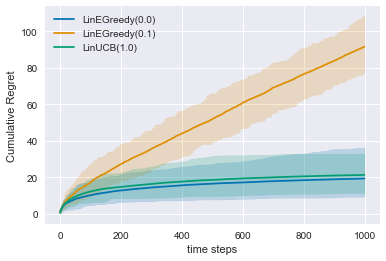

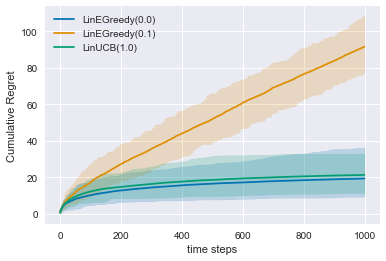

In [26]:
plot_result(linucb_vs_greedy)

## LinTS : Taking the Bayesian way

Thompson Sampling is a popular bayesian alternative to the standard optimistic bandit algorithms (see Chapter 36 of Bandit Algorithms). The key idea is to rely on Bayesian *samples* to get a proxy for the hidden parameter $\theta$ of the problem instead of building high-probability confidence regions.

* **Posterior derivation**: Let us place a Gaussian prior with mean $\mathbf{0}$ and covariance $\lambda I$ on $\theta$. Given actions $A_1,\ldots,A_t$ and rewards $Y_1,\ldots,Y_t$, Can you compute the expression of the posterior at the beginning of round $t+1$ ?

The posterior is
$$
p(\theta|A_1,Y_1,\ldots,A_t,Y_t) \propto p(A_1,Y_1,\ldots,A_t,Y_t|\theta)p(\theta) \sim \mathcal{N}(\hat{\theta}_t, V^{-1}_t)
$$
A nice way to see this is via the maximum likelihood problem (see https://perso.telecom-paristech.fr/bonald/documents/bandit.pdf) or via the traditional Bayesian posterior derivations for Gaussians with known variance (see https://www.cs.toronto.edu/~rgrosse/courses/csc411_f18/slides/lec19-slides.pdf)

So to implement LinTS, one has to sample from the posterior a *hallucinated* parameter $\tilde{\theta}$ and then use this parameter to evaluate the mean of each arm in the action set at round $t$. Note that the sampling step *replaces* the bonus in LinUCB.


* **Implementation of a LinTS (Linear Thompson Sampling) agent**.

In [27]:
class LinTS(Agent):

  def __init__(self, d, delta, lambda_prior):
    self.d = d
    self.delta = delta
    self.lambda_prior = lambda_prior
    self.cov = self.lambda_prior * np.identity(d)
    self.reset()

  def reset(self):
    # reset all local variables that should not be kept when the experiment is restarted
    self.t = 0
    self.hat_theta = np.zeros(self.d)
    self.cov = self.lambda_prior * np.identity(self.d)
    self.invcov = np.identity(self.d)
    self.b_t = np.zeros(self.d)


  def get_action(self, arms):
    """
        This function implements LinUCB
        Input:
        -------
        arms : list of arms (d-dimensional vectors)

        Output:
        -------
        chosen_arm : vector (chosen arm array of features)
        """

    K, _ = arms.shape
    estimated_means = np.zeros(K)

    #your code starts here:
    hallucinated_theta = np.random.multivariate_normal(self.hat_theta, self.invcov)
    #ends here

    for i in range(K):
        estimated_means[i] = np.dot(hallucinated_theta,arms[i,:])


    #choose arm with largest estimated mean
    chosen_arm_index = np.argmax(estimated_means)
    chosen_arm = arms[chosen_arm_index]


    return chosen_arm



  def receive_reward(self, chosen_arm, reward):
    """
    update the internal quantities required to estimate the parameter theta using least squares
    """
    xxt = np.outer(chosen_arm, chosen_arm.T)
    self.cov += xxt
#     self.invcov = pinv(self.cov)
    self.invcov = pinv(self.cov)

    self.b_t += reward * chosen_arm

    self.hat_theta = np.inner(self.invcov, self.b_t) # update the least square estimate
    self.t += 1

    pass


  def name(self):
    return "LinTS"

# Is Thompson Sampling better than LinUCB?
Compare these two policies in all environments and conclude.

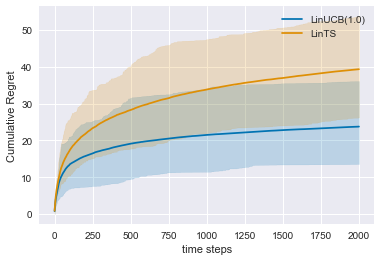

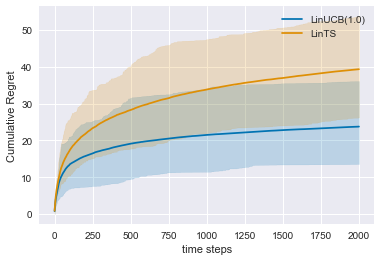

In [28]:
T=2000
N=50

linucb.reset()
ts = LinTS(d, delta, lambda_prior=1.)

linucb_vs_ts = experiment_linb(iid_env, [linucb, ts], Nmc=N, T=T)

plot_result(linucb_vs_ts, q=10)